In [1]:
import os
import wrds
import pandas as pd
import numpy as np
from timeit import default_timer as timer
import datetime
from utils import summary_stats, stats_with_description
import requests
from bs4 import BeautifulSoup
from soup2dict import convert
from urllib.parse import urljoin, urlparse
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import time

# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
# set folders
CHECKPOINT_FOLDER = '.\\Checkpoints'
CODING_TABLES_FOLDER = '.\\Coding_tables'
STATS_FOLDER = '.\\Stats'


if not os.path.exists(CHECKPOINT_FOLDER):
        os.makedirs(CHECKPOINT_FOLDER)
if not os.path.exists(STATS_FOLDER):
        os.makedirs(STATS_FOLDER)

In [3]:
# connect
db = wrds.Connection(wrds_username = 'kglim')

Loading library list...
Done


In [4]:
# useful commands


# sorted(db.list_libraries())

# sorted(db.list_tables(library='ibes'))

# db.get_row_count(library='wrdsapps', table='firm_ratio_ibes')

# db.describe_table(library='wrdsapps', table='firm_ratio_ibes')

# db.get_table(library='ibes', table='act_epsint', obs = 100)

# https://wrds-www.wharton.upenn.edu/pages/support/programming-wrds/programming-python/querying-wrds-data-python/

## Download Earnings Per Share

In [4]:
# https://wrds-www.wharton.upenn.edu/pages/get-data/ibes-thomson-reuters/ibes-academic/detail-history/actuals/

LIB = 'ibes'
TAB = ['act_epsint', 'act_epsus']
MIN_DATE = '01/01/2010'
FREQ = 'ANN'                                   # frequency of data 'ANN', 'QRT', 'SAN'
DATE_FILTER = 'pends'                          # date to be used for filtering
DATE_COLS = ['pends', 'anndats', 'actdats']    # columns to be converted into date
HOURS_COLS = ['anntims', 'acttims']            # columns to be converted into hours, minutes, seconds

In [12]:
# get column list

pd.set_option('display.max_rows', 100)
db.describe_table(library=LIB, table=TAB[0])

Approximately 3024818 rows in ibes.act_epsint.


,name,nullable,type,comment
0,ticker,True,VARCHAR(6),None
1,cusip,True,VARCHAR(8),None
2,oftic,True,VARCHAR(6),None
3,cname,True,VARCHAR(16),None
4,pends,True,DATE,None
5,measure,True,VARCHAR(6),None
6,pdicity,True,VARCHAR(3),None
7,anndats,True,DATE,None
8,anntims,True,DOUBLE_PRECISION,None
9,actdats,True,DATE,None


In [ ]:
# download data

df_EPS = pd.DataFrame()
for tb in TAB:
    
    print('-- Downloading ', tb, '\n')
    query = [
        " select * from " + LIB + "." + tb,
        "where " + DATE_FILTER + ">='" + MIN_DATE +"' and pdicity='" + FREQ + "'"
    ]

    print('Query:\n', '\n'.join(query))

    start = timer()
    print('\n\nQuerying...', end='')
    df_t = db.raw_sql('\n'.join(query), date_cols=DATE_COLS + HOURS_COLS)
    print(' Elapsed time:', str(datetime.timedelta(seconds=round(timer()-start))))
    print('  Total rows:', df_t.shape[0], '\n\n')
    df_EPS = df_EPS.append(df_t)
    del df_t

# convert times to hours, minutes, seconds
for col in HOURS_COLS:
    df_EPS[col] = df_EPS[col].dt.strftime('%H:%M:%S')
    
print('\nDatabase size:', df_EPS.shape)

df_EPS.to_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_EPS_raw.pkl'), protocol=-1)
print('\nPickle saved to', os.path.join(CHECKPOINT_FOLDER, 'df_EPS_raw.pkl'))

-- Downloading  act_epsint 

Query:
  select * from ibes.act_epsint
where pends>='01/01/2010' and pdicity='ANN'


Querying...

In [158]:
df_EPS = pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_EPS_raw.pkl'))

In [14]:
# stats

df_EPS_stats = stats_with_description(df_EPS, os.path.join(CODING_TABLES_FOLDER, LIB + '.' + TAB[0] + '.csv'))
df_EPS_stats.to_csv(os.path.join(STATS_FOLDER, '00_ibes_EPS_raw_stats.csv'), index=False, sep=';')
print('Stats saved to', os.path.join(STATS_FOLDER, '00_ibes_EPS_raw_stats.csv'))

Stats saved to .\Stats\00_ibes_EPS_stats.csv


In [36]:
# check usfirm
# USFIRM=0 if from .INT, and USFIRM=1 if from .US file

display(df_EPS.usfirm.value_counts().to_frame())

check_usfirm = df_EPS.groupby('cusip')['usfirm'].nunique().to_frame()
check_usfirm_multi = check_usfirm[check_usfirm['usfirm'] > 1]
print('-', check_usfirm_multi.shape[0], 'firms with multiple "usfirm". Check "check_usfirm_multi"')
# df_EPS[df_EPS.cusip == "9891391X"].sort_values(by=['pends'])

,usfirm
0.0,346743
1.0,70397


- 63 firms with multiple "usfirm". Check "check_usfirm_multi"


In [58]:
# check ESP and EPSPAR

df_EPS.groupby('measure').agg(
    Tot_NA=('value', lambda x: np.isnan(x).sum()),
    Tot_obs=('value', lambda x: len(x))
).assign(
    perc = lambda x: np.round(x.Tot_NA / x.Tot_obs * 100, 2),
    valid_obs = lambda x: x.Tot_obs - x.Tot_NA
)

,Tot_NA,Tot_obs,perc,valid_obs
measure,,,,
EPS,108715,347120,31.32,238405
EPSPAR,29884,70020,42.68,40136


C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


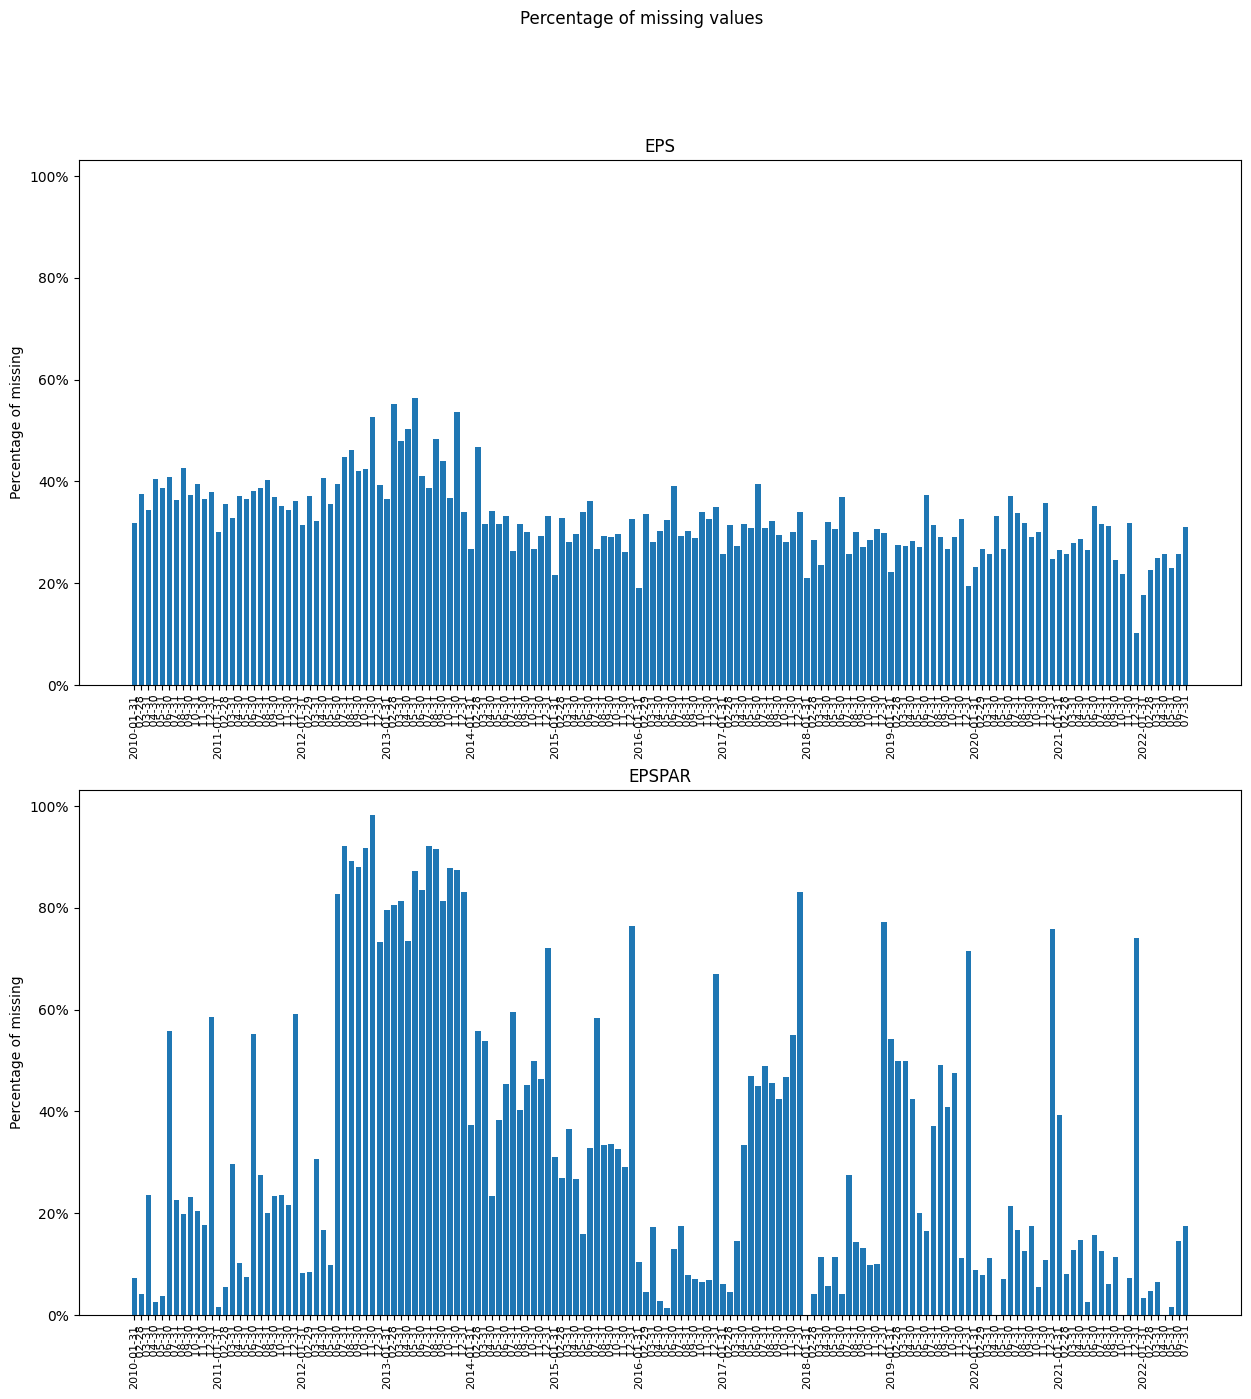

In [159]:
# plot missing percentage

plot_data = df_EPS.groupby(['pends', 'measure']).agg(
    Tot_NA=('value', lambda x: np.isnan(x).sum()),
    Tot_obs=('value', lambda x: len(x))
).reset_index().assign(
    perc = lambda x: np.round(x.Tot_NA / x.Tot_obs * 100, 2)
)#.set_index('pends')
plot_data['pends'] = pd.to_datetime(plot_data['pends']).dt.strftime('%Y-%m-%d')

fig, ax = plt.subplots(2, 1, figsize=(15, 15), sharey=True, sharex=False)
ax = ax.flatten()
ax_c = 0

for meas in plot_data['measure'].unique():

    dd = plot_data[plot_data['measure'] == meas].sort_values(by=['pends'])[['pends', 'perc']]
    labels = [time.strptime(x, '%Y-%m-%d') for x in dd.pends.values]
    labels = [time.strftime('%Y-%m-%d', x) if x.tm_mon == 1 else time.strftime('     %m-%d', x) for x in labels]
    ax[ax_c].bar(dd['pends'], dd['perc'])
    ax[ax_c].tick_params(axis='x', labelrotation=90, labelsize = 8)
    ax[ax_c].set_xticklabels(labels)
    ax[ax_c].set_title(meas)
    ax[ax_c].set_ylabel('Percentage of missing')
    ax[ax_c].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax_c += 1
fig.suptitle('Percentage of missing values')
plt.show()

### filter for non missing EPS and consecutive years only

In [408]:
df_EPS_final = df_EPS.copy()
df_EPS_final = df_EPS_final.assign(
    year = lambda x: x.pends.astype('datetime64[D]').dt.strftime('%Y').astype(int),
    announce = lambda x: pd.to_datetime(x.anndats.astype('datetime64[D]').dt.strftime('%Y-%m-%d') + ' ' + x.anntims),
    activation = lambda x: pd.to_datetime(x.actdats.astype('datetime64[D]').dt.strftime('%Y-%m-%d') + ' ' + x.acttims)
)
df_EPS_final = df_EPS_final[df_EPS_final['measure'] == 'EPS']
df_EPS_final = df_EPS_final[~df_EPS_final['value'].isnull()]
df_EPS_final = df_EPS_final[~df_EPS_final['cname'].isnull()]
df_EPS_final = df_EPS_final[df_EPS_final['cusip'] != '00000000']
df_EPS_final.drop(columns=['measure', 'pdicity', 'anndats', 'anntims', 'actdats', 'acttims'], inplace=True)
df_EPS_final.head(5)

,ticker,cusip,oftic,cname,pends,value,curr_act,usfirm,year,announce,activation
8,@1B8,FJB1NWD4,3071,STREAM CO LTD,2010-01-31,5.1972,JPY,0.0,2010,2010-03-12,2010-03-12 04:40:24
11,@2BD,FJ653207,2738,BALS CORP,2010-01-31,5785.6800,JPY,0.0,2010,2010-03-05,2010-03-05 03:26:47
14,@2N9,FJB1Z8XW,4369,TRI CHEMICAL,2010-01-31,-5.3775,JPY,0.0,2010,2010-03-15,2010-03-15 05:19:15
16,@2OM,FJ617475,7614,OM2 NETWORK,2010-01-31,67.8800,JPY,0.0,2010,2010-03-12,2010-03-12 04:40:28
18,@2Q3,FJB1ZBYJ,3246,KOSE R.E. CO LTD,2010-01-31,-22.2580,JPY,0.0,2010,2010-03-17,2010-03-17 05:38:26


In [409]:
# check ticker

check_ticker = df_EPS_final.groupby('cusip')['ticker'].nunique().to_frame().reset_index()
print('Group by "cusip", count of "ticker" (IBES ticker):\n', check_ticker['ticker'].value_counts().to_frame())

print('\n\n--- Removing multiple ticker')
cusip_mult = check_ticker[check_ticker['ticker'] > 1]['cusip'].values
df_EPS_final = df_EPS_final[~df_EPS_final['cusip'].isin(cusip_mult)]
check_ticker = df_EPS_final.groupby('cusip')['ticker'].nunique().to_frame().reset_index()
print('\nGroup by "cusip", count of "ticker" (IBES ticker):\n', check_ticker['ticker'].value_counts().to_frame())

print('\n--- Removing multiple announce date (take last)')
df_EPS_final = df_EPS_final.sort_values(by=['activation']).groupby(['ticker', 'year']).last().reset_index()
check_year = df_EPS_final.groupby('ticker').agg(
    duplicates=('year', lambda x: len(x) - len(np.unique(x)))
).reset_index()
print('\nGroup by "ticker", count of duplicated "year":\n', check_year['duplicates'].value_counts().to_frame())

check_ticker = df_EPS_final.groupby('cusip')['ticker'].nunique().to_frame().reset_index()
print('\n\nGroup by "cusip", count of "ticker":\n', check_ticker['ticker'].value_counts().to_frame())
check_cusip = df_EPS_final.groupby('ticker')['cusip'].nunique().to_frame().reset_index()
print('\nGroup by "ticker", count of "cusip" (cusip may change over years):\n', check_cusip['cusip'].value_counts().to_frame())
check_oftic = df_EPS_final.groupby('cusip')['oftic'].nunique().to_frame().reset_index()
print('\nGroup by "cusip", count of "oftic" (cusip may change over years):\n', check_oftic['oftic'].value_counts().to_frame())

print('\n\n--- "ticker" is the unique identifier for each company.', df_EPS_final['ticker'].nunique(), 'found.')

df_EPS_final.to_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_EPS_final.pkl'), protocol=-1)
print('\n--- Pickle saved to', os.path.join(CHECKPOINT_FOLDER, 'df_EPS_final.pkl'))

df_EPS_final_stats = stats_with_description(df_EPS_final, os.path.join(CODING_TABLES_FOLDER, LIB + '.' + TAB[0] + '.csv'))
df_EPS_final_stats.to_csv(os.path.join(STATS_FOLDER, '00_ibes_EPS_final_stats.csv'), index=False, sep=';')
print('Stats saved to', os.path.join(STATS_FOLDER, '00_ibes_EPS_final_stats.csv'))

Group by "cusip", count of "ticker" (IBES ticker):
    ticker
1   41791
2      54


--- Removing multiple ticker

Group by "cusip", count of "ticker" (IBES ticker):
    ticker
1   41791

--- Removing multiple announce date (take last)

Group by "ticker", count of duplicated "year":
    duplicates
0       37818


Group by "cusip", count of "ticker":
    ticker
1   41790

Group by "ticker", count of "cusip" (cusip may change over years):
     cusip
1   34495
2    2825
3     400
4      73
5      11
6       7
7       3
8       2
9       1
10      1

Group by "cusip", count of "oftic" (cusip may change over years):
    oftic
1  39117
2   2201
0    357
3    111
4      3
5      1


--- "ticker" is the unique identifier for each company. 37818 found.

--- Pickle saved to .\Checkpoints\df_EPS_final.pkl


## Download financial ratios (with IBES subscription)

In [10]:
# https://wrds-www.wharton.upenn.edu/pages/get-data/financial-ratios-suite-wrds/financial-ratios-with-ibes-subscription/financial-ratios-firm-level-ibes/

LIB = 'wrdsapps'
TAB = 'firm_ratio_ibes'
MIN_DATE = '01/01/2010'
DATE_FILTER = 'public_date'                      # date to be used for filtering
DATE_COLS = ['public_date', 'adate', 'qdate']    # columns to be converted into date


In [5]:
# get column list
pd.set_option('display.max_rows', 100)
db.describe_table(library=LIB, table=TAB)

Approximately 2703490 rows in wrdsapps.firm_ratio_ibes.


,name,nullable,type,comment
0,gvkey,True,VARCHAR(6),None
1,permno,True,DOUBLE_PRECISION,None
2,adate,True,DATE,None
3,qdate,True,DATE,None
4,public_date,True,DATE,None
5,capei,True,DOUBLE_PRECISION,None
6,be,True,DOUBLE_PRECISION,None
7,bm,True,DOUBLE_PRECISION,None
8,evm,True,DOUBLE_PRECISION,None
9,pe_op_basic,True,DOUBLE_PRECISION,None


In [16]:
# download data
query = [
    " select * from " + LIB + "." + TAB,
    "where " + DATE_FILTER + ">='" + MIN_DATE +"'"    
]

print('Query:\n', '\n'.join(query))

start = timer()
print('\n\nQuerying...', end='')
df_ratios = db.raw_sql('\n'.join(query), date_cols=DATE_COLS)
print(' Total elapsed time:', str(datetime.timedelta(seconds=round(timer()-start))))
print('\nDatabase size:', df_ratios.shape)

df_ratios.to_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_ratios_raw.pkl'), protocol=-1)
print('\nPickle saved to', os.path.join(CHECKPOINT_FOLDER, 'df_ratios_raw.pkl'))

Query:
  select * from wrdsapps.firm_ratio_ibes
where public_date>='01/01/2010'


Querying... Total elapsed time: 0:02:26

Database size: (528785, 100)

Pickle saved to ./Checkpoints\df_ratios_raw.pkl


In [59]:
# stats
df_ratios = pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_ratios_raw.pkl'))

df_ratios_stats = stats_with_description(df_ratios, os.path.join(CODING_TABLES_FOLDER, LIB + '.' + TAB + '.csv'))
df_ratios_stats.to_csv(os.path.join(STATS_FOLDER, '00_ibes_finratio_raw_stats.csv'), index=False, sep=';')
print('Stats saved to', os.path.join(STATS_FOLDER, '00_ibes_finratio_raw_stats.csv'))

Stats saved to .\Stats\00_ibes_finratio_stats.csv


In [352]:
aa[aa.ticker == "@60X"].sort_values(by=['pends'])

,ticker,cusip,pends,announce,oftic,cname,value,curr_act,usfirm,year,activation
41061,@60X,FAB4YT7M,2010-12-31,2011-02-14 00:00:00,9136,JU TENG INTL HOL,0.284,HKD,0.0,2010,2011-04-14 04:44:14
41062,@60X,FAB4YT7M,2011-12-31,2012-02-26 19:16:00,9136,JU TENG INTL HOL,0.880,TWD,0.0,2011,2013-02-14 10:00:19
41063,@60X,FAB4YT7M,2012-12-31,2013-04-03 04:31:00,9136,JU TENG INTL HOL,1.920,TWD,0.0,2012,2013-07-23 01:27:38
41064,@60X,FAB4YT7M,2013-12-31,2014-03-26 04:59:00,9136,JU TENG INTL HOL,2.430,TWD,0.0,2013,2014-03-26 05:27:03
41065,@60X,FAB4YT7M,2014-12-31,2015-03-17 04:16:00,9136,JU TENG INTL,2.450,TWD,0.0,2014,2015-03-18 04:29:39
41066,@60X,FAB4YT7M,2015-12-31,2016-04-07 21:39:00,9136,JU TENG INTL,0.747,HKD,0.0,2015,2016-08-18 10:43:38


In [ ]:
check_cusip = df_EPS_final.groupby('ticker')['year'].nunique().to_frame().reset_index()

In [209]:
df_EPS_final.groupby('ticker')['cusip'].nunique().to_frame().reset_index()

,ticker,cusip
0,0000,1
1,0001,1
2,0003,1
3,0004,1
4,000R,1
...,...,...
37813,ZY,1
37814,ZYNE,1
37815,ZYNX,1
37816,ZZE1,1


In [210]:
check_cusip = df_EPS_final.groupby('ticker')['cusip'].nunique().to_frame().reset_index()
print('\nGroup by "ticker", count of "cusip":\n', check_cusip['cusip'].value_counts().to_frame())


Group by "ticker", count of "cusip":
     cusip
1   34494
2    2826
3     400
4      73
5      11
6       7
7       3
8       2
9       1
10      1


In [141]:
check_ticker[check_ticker.cusip==3]

,ticker,cusip
35,0034,3
68,006Q,3
125,00DJ,3
198,00RA,3
203,00RX,3
...,...,...
37568,WTE1,3
37650,XOMA,3
37672,XRX,3
37697,YELL,3


In [138]:
df_EPS_final[df_EPS_final.cusip == "28622110"].sort_values(by=['pends'])

,ticker,cusip,oftic,cname,pends,measure,pdicity,anndats,anntims,actdats,acttims,value,curr_act,usfirm
69,001A,28622110,EBIO,ELEVEN,2014-12-31,EPS,ANN,2015-03-04,07:30:00,2015-03-04,07:39:20,-2.37,USD,1.0
70,001A,28622110,EBIO,ELEVEN,2015-12-31,EPS,ANN,2016-03-24,07:30:00,2016-03-24,07:43:36,-1.76,USD,1.0
71,001A,28622110,EBIO,ELEVEN,2016-12-31,EPS,ANN,2017-03-24,07:00:00,2017-03-24,07:04:12,0.04,USD,1.0
72,001A,28622110,EBIO,ELEVEN,2017-12-31,EPS,ANN,2018-04-02,22:55:00,2018-04-02,22:55:51,-1.11,USD,1.0


In [139]:
df_EPS_final[df_EPS_final.cusip == "81776310"].sort_values(by=['pends'])

,ticker,cusip,oftic,cname,pends,measure,pdicity,anndats,anntims,actdats,acttims,value,curr_act,usfirm
73,001A,81776310,SESN,SESEN BIO,2018-12-31,EPS,ANN,2019-03-01,17:54:00,2019-03-01,18:10:40,-0.55,USD,1.0
74,001A,81776310,SESN,SESEN BIO,2019-12-31,EPS,ANN,2020-03-16,07:00:00,2020-03-16,07:35:22,-1.18,USD,1.0
75,001A,81776310,SESN,SESEN BIO,2020-12-31,EPS,ANN,2021-03-15,07:00:00,2021-03-15,07:43:15,-0.19,USD,1.0
76,001A,81776310,SESN,SESEN BIO,2021-12-31,EPS,ANN,2022-02-28,08:00:00,2022-02-28,08:24:58,0.00,USD,1.0


In [261]:
df_EPS_final.year = df_EPS_final.pends.dt.strftime('%Y')

C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [224]:
df_EPS_final.year = df_EPS_final.pends.astype('datetime64[Y]')

AttributeError: 'Series' object has no attribute 'strftime'

In [265]:
df_EPS_final.pends.dt.strftime('%Y')

8        2010
11       2010
14       2010
16       2010
18       2010
         ... 
70392    2017
70393    2018
70394    2019
70395    2020
70396    2021
Name: pends, Length: 235375, dtype: object

In [301]:
df_EPS_final.pends = df_EPS_final.pends.astype('datetime64[D]')

C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [302]:
df_EPS_final.pends.values[0]

numpy.datetime64('2010-01-31T00:00:00.000000000')

In [295]:
df_EPS_final.assign(
    year = lambda x: x.pends.astype('datetime64[D]').dt.strftime('%Y')
)

,ticker,cusip,oftic,cname,pends,measure,pdicity,anndats,anntims,actdats,acttims,value,curr_act,usfirm,year
8,@1B8,FJB1NWD4,3071,STREAM CO LTD,2010-01-31,EPS,ANN,2010-03-12,00:00:00,2010-03-12,04:40:24,5.1972,JPY,0.0,2010
11,@2BD,FJ653207,2738,BALS CORP,2010-01-31,EPS,ANN,2010-03-05,00:00:00,2010-03-05,03:26:47,5785.6800,JPY,0.0,2010
14,@2N9,FJB1Z8XW,4369,TRI CHEMICAL,2010-01-31,EPS,ANN,2010-03-15,00:00:00,2010-03-15,05:19:15,-5.3775,JPY,0.0,2010
16,@2OM,FJ617475,7614,OM2 NETWORK,2010-01-31,EPS,ANN,2010-03-12,00:00:00,2010-03-12,04:40:28,67.8800,JPY,0.0,2010
18,@2Q3,FJB1ZBYJ,3246,KOSE R.E. CO LTD,2010-01-31,EPS,ANN,2010-03-17,00:00:00,2010-03-17,05:38:26,-22.2580,JPY,0.0,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70392,ZYNX,98986M10,ZYXI,ZYNEX INC,2017-12-31,EPS,ANN,2018-02-28,09:05:00,2018-02-28,10:39:29,0.2000,USD,1.0,2017
70393,ZYNX,98986M10,ZYXI,ZYNEX INC,2018-12-31,EPS,ANN,2019-02-26,16:01:00,2019-02-26,16:08:51,0.2545,USD,1.0,2018
70394,ZYNX,98986M10,ZYXI,ZYNEX INC,2019-12-31,EPS,ANN,2020-02-27,16:02:00,2020-02-27,17:09:16,0.2545,USD,1.0,2019
70395,ZYNX,98986M10,ZYXI,ZYNEX INC,2020-12-31,EPS,ANN,2021-02-25,17:05:00,2021-02-25,17:45:38,0.2364,USD,1.0,2020


In [213]:
df_EPS_final.pends.values[0]

numpy.datetime64('2010-01-31T00:00:00.000000000')

In [228]:
time.strftime('%Y-%m-%d', df_EPS_final.pends.values[0].astype('datetime64[Y]'))

TypeError: Tuple or struct_time argument required

In [231]:
df_EPS_final.pends.values[0].astype('datetime64[Y]').datetime_as_string()


AttributeError: 'numpy.datetime64' object has no attribute 'datetime_as_string'

In [142]:
df_EPS_final[df_EPS_final.ticker == "0034"].sort_values(by=['pends'])

,ticker,cusip,oftic,cname,pends,measure,pdicity,anndats,anntims,actdats,acttims,value,curr_act,usfirm
134151,0034,20651910,CXR,CONCORDIA HLTHCR,2014-12-31,EPS,ANN,2015-03-19,17:00:00,2015-03-19,17:19:31,564.00,USD,0.0
161857,0034,20651910,CXR,CONCORDIA HLTHCR,2015-12-31,EPS,ANN,2016-03-23,17:00:00,2016-03-23,18:47:31,1314.00,USD,0.0
190733,0034,20653P10,CXR,CONCORDIA HLTHCR,2016-12-31,EPS,ANN,2017-03-15,07:00:00,2017-03-16,07:58:57,1068.00,USD,0.0
220064,0034,20653P10,CXR,CONCORDIA HLTHCR,2017-12-31,EPS,ANN,2018-03-08,13:13:00,2018-03-08,13:14:04,54.00,USD,0.0
248590,0034,00775M10,ADVZ,ADVANZ PHARMA,2018-12-31,EPS,ANN,2019-03-14,07:04:00,2019-03-14,12:00:43,-1.26,USD,0.0
275210,0034,00775M10,ADVZ,ADVANZ PHARM,2019-12-31,EPS,ANN,2020-03-25,07:00:00,2020-03-25,09:08:53,-1.11,USD,0.0


In [ ]:
# check consecutive years

In [126]:
check_oftic[check_oftic.oftic == 2]

,cusip,oftic
11,00081T10,2
22,00101J10,2
32,00120410,2
49,00174410,2
52,00176510,2
...,...,...
41597,SSBZBW6G,2
41607,T1872V28,2
41615,T8200011,2
41710,Y2685T11,2


In [127]:
df_EPS_final[df_EPS_final.cusip == "00081T10"].sort_values(by=['pends'])

,ticker,cusip,oftic,cname,pends,measure,pdicity,anndats,anntims,actdats,acttims,value,curr_act,usfirm
4414,ABDW,00081T10,ABD,ACCO BRANDS CORP,2010-12-31,EPS,ANN,2011-02-09,07:00:00,2011-02-09,07:12:09,0.53,USD,1.0
4415,ABDW,00081T10,ABD,ACCO BRANDS CORP,2011-12-31,EPS,ANN,2012-02-15,07:00:00,2012-02-15,07:15:56,0.64,USD,1.0
4416,ABDW,00081T10,ACCO,ACCO BRANDS CORP,2012-12-31,EPS,ANN,2013-02-13,07:02:00,2013-02-13,07:14:43,1.02,USD,1.0
4417,ABDW,00081T10,ACCO,ACCO BRANDS CORP,2013-12-31,EPS,ANN,2014-02-12,07:00:00,2014-02-12,07:36:52,0.77,USD,1.0
4418,ABDW,00081T10,ACCO,ACCO BRANDS CORP,2014-12-31,EPS,ANN,2015-02-11,07:00:00,2015-02-11,07:54:24,0.80,USD,1.0
4419,ABDW,00081T10,ACCO,ACCO BRANDS CORP,2015-12-31,EPS,ANN,2016-02-10,07:01:00,2016-02-10,07:57:55,0.78,USD,1.0
4420,ABDW,00081T10,ACCO,ACCO BRANDS CORP,2016-12-31,EPS,ANN,2017-02-22,07:00:00,2017-02-22,07:20:16,0.87,USD,1.0
4421,ABDW,00081T10,ACCO,ACCO BRANDS CORP,2017-12-31,EPS,ANN,2018-02-14,06:40:00,2018-02-14,07:15:12,1.19,USD,1.0
4422,ABDW,00081T10,ACCO,ACCO BRANDS CORP,2018-12-31,EPS,ANN,2019-02-13,06:40:00,2019-02-13,06:52:42,1.14,USD,1.0
4423,ABDW,00081T10,ACCO,ACCO BRANDS CORP,2019-12-31,EPS,ANN,2020-02-11,16:30:00,2020-02-11,17:37:22,1.20,USD,1.0


In [46]:
aa = df_EPS.groupby('cname')['cusip'].nunique().to_frame()
aa

,cusip
cname,
&DO HLDG,1
01 COMMNQUE. LAB,1
1 1,1
1 CO,1
1&1 DRILLISCH,1
...,...
ZYTRONIC PLC,1
ZZ GL TECH,1
ZZ HUARUI TOOLS,1


In [47]:
aa.cusip.value_counts()

1     55202
2      5422
3       959
4       300
5        71
6        35
8        14
7        10
9         5
10        3
12        1
13        1
Name: cusip, dtype: int64

In [48]:
aa[aa.cusip == 2]

,cusip
cname,
1PM PLC,2
1SPATIAL,2
1ST BUSEY CORP/A,2
1ST FED BNCS/ARK,2
20 MICRONS LTD.,2
...,...
ZUEBLIN,2
ZURICH FINANCIAL,2
ZURICH INS GROUP,2


In [50]:
pd.set_option('display.max_rows', 20)
df_EPS[df_EPS.cname == '20 MICRONS LTD.'].sort_values(by=['pends'])

,ticker,cusip,oftic,cname,pends,measure,pdicity,anndats,anntims,actdats,acttims,value,curr_act,usfirm
1266,@2N,FIB2QY47,20ML,20 MICRONS LTD.,2010-03-31,EPSPAR,ANN,2010-06-01,04:50:00,2010-06-01,04:52:02,NaN,INR,0.0
32491,@2N,FIB2QY47,20ML,20 MICRONS LTD.,2011-03-31,EPSPAR,ANN,2011-05-20,02:46:00,2011-05-20,03:09:04,NaN,INR,0.0
63246,@2N,FIB2QY47,20ML,20 MICRONS LTD.,2012-03-31,EPS,ANN,2012-05-23,09:30:00,2012-05-23,09:31:18,NaN,INR,0.0
63247,@2N,FIB2QY47,20ML,20 MICRONS LTD.,2012-03-31,EPSPAR,ANN,2012-05-23,09:30:00,2012-05-23,09:31:18,NaN,INR,0.0
93650,@2N,FIB96BWP,20ML,20 MICRONS LTD.,2013-03-31,EPS,ANN,2013-05-28,08:25:00,2013-05-28,08:42:20,NaN,INR,0.0
93651,@2N,FIB96BWP,20ML,20 MICRONS LTD.,2013-03-31,EPSPAR,ANN,2013-05-28,08:25:00,2013-05-28,08:42:20,NaN,INR,0.0
123531,@2N,FIB96BWP,None,20 MICRONS LTD.,2014-03-31,EPS,ANN,2014-05-24,10:30:00,2014-05-26,15:54:41,NaN,INR,0.0
151575,@2N,FIB96BWP,None,20 MICRONS LTD.,2015-03-31,EPS,ANN,2015-05-27,06:30:00,2015-06-12,04:56:54,NaN,INR,0.0
179861,@2N,FIB96BWP,None,20 MICRONS LTD.,2016-03-31,EPS,ANN,2016-05-23,13:30:00,2016-06-15,13:30:53,NaN,INR,0.0
209429,@2N,FIB96BWP,None,20 MICRONS LTD.,2017-03-31,EPS,ANN,2017-05-25,07:09:00,2017-05-25,08:20:22,NaN,INR,0.0


In [182]:
aa = df_EPS.groupby('cusip')['cname'].nunique().to_frame()
aa

,cname
cusip,
00000000,11
000000MW,1
00001216,2
00004006,1
00025510,2
...,...
Y9033U10,1
Y9369110,1
Y9384M10,1


In [205]:
aa.cname.value_counts()

AttributeError: 'DataFrame' object has no attribute 'cname'

In [196]:
aa[aa.cname == 1]

,cname
cusip,
000000MW,1
00004006,1
00032Q10,1
00036020,1
00038020,1
...,...
Y9033U10,1
Y9369110,1
Y9384M10,1


In [195]:
df_EPS[df_EPS.cusip == "20732410"].sort_values(by=['pends'])

,ticker,cusip,oftic,cname,pends,measure,pdicity,anndats,anntims,actdats,acttims,value,curr_act,usfirm
30420,CNF1,20732410,CFF,CONIFEX TIMBER,2010-12-31,EPS,ANN,2011-03-08,17:05:00,2011-09-20,14:16:18,NaN,CAD,0.0
61239,CNF1,20732410,CFF,CONIFEX TIMBER,2011-12-31,EPS,ANN,2012-02-21,16:05:00,2012-02-24,07:56:24,-1.11,CAD,0.0
91733,CNF1,20732410,CFF,CONIFEX TIMBER,2012-12-31,EPS,ANN,2013-02-22,19:25:00,2013-02-24,20:33:32,-0.86,CAD,0.0
121664,CNF1,20732410,CFF,CONIFEX TIMBER,2013-12-31,EPS,ANN,2014-02-21,16:00:00,2014-02-21,16:24:16,0.46,CAD,0.0
149754,CNF1,20732410,CFF,CONFIEX TIMBER,2014-12-31,EPS,ANN,2015-02-25,16:00:00,2015-02-25,16:09:09,0.22,CAD,0.0
177997,CNF1,20732410,CFF,CONFIEX TIMBER,2015-12-31,EPS,ANN,2016-02-22,08:01:00,2016-02-22,08:46:29,-0.82,CAD,0.0
207493,CNF1,20732410,CFF,CONFIEX TIMBER,2016-12-31,EPS,ANN,2017-02-15,08:00:00,2017-02-15,08:13:25,0.93,CAD,0.0
236446,CNF1,20732410,CFF,CONFIEX TIMBER,2017-12-31,EPS,ANN,2018-02-16,08:38:00,2018-02-16,08:39:01,0.67,CAD,0.0
263638,CNF1,20732410,CFF,CONIFEX TIMB,2018-12-31,EPS,ANN,2019-03-27,08:03:00,2019-03-27,08:44:55,-0.19,CAD,0.0
289117,CNF1,20732410,CFF,CONIFEX,2019-12-31,EPS,ANN,2020-03-11,08:00:00,2020-03-11,10:00:55,-1.52,CAD,0.0


In [203]:
df_EPS[df_EPS.oftic == "UNM"].sort_values(by=['pends'])

,ticker,cusip,oftic,cname,pends,measure,pdicity,anndats,anntims,actdats,acttims,value,curr_act,usfirm
65183,UNM,91529Y10,UNM,UNUM GROUP,2010-12-31,EPS,ANN,2011-02-02,16:00:00,2011-02-02,16:06:46,2.70,USD,1.0
65184,UNM,91529Y10,UNM,UNUM GROUP,2011-12-31,EPS,ANN,2012-02-06,15:59:00,2012-02-06,16:25:51,2.87,USD,1.0
65185,UNM,91529Y10,UNM,UNUM GROUP,2012-12-31,EPS,ANN,2013-02-05,16:00:00,2013-02-05,16:03:17,3.15,USD,1.0
65186,UNM,91529Y10,UNM,UNUM GROUP,2013-12-31,EPS,ANN,2014-02-04,16:00:00,2014-02-04,16:07:29,3.32,USD,1.0
65187,UNM,91529Y10,UNM,UNUM GRP,2014-12-31,EPS,ANN,2015-02-03,16:00:00,2015-02-03,16:11:33,3.55,USD,1.0
65188,UNM,91529Y10,UNM,UNUM GROUP,2015-12-31,EPS,ANN,2016-02-02,16:15:00,2016-02-02,17:27:27,3.64,USD,1.0
65189,UNM,91529Y10,UNM,UNUM GROUP,2016-12-31,EPS,ANN,2017-02-01,16:15:00,2017-02-01,17:38:28,3.92,USD,1.0
65190,UNM,91529Y10,UNM,UNUM GROUP,2017-12-31,EPS,ANN,2018-01-31,18:47:00,2018-01-31,18:57:41,4.29,USD,1.0
65191,UNM,91529Y10,UNM,UNUM GROUP,2018-12-31,EPS,ANN,2019-02-05,16:15:00,2019-02-05,17:51:25,5.20,USD,1.0
65192,UNM,91529Y10,UNM,UNUM GROUP,2019-12-31,EPS,ANN,2020-02-04,16:15:00,2020-02-04,17:48:33,5.44,USD,1.0


In [179]:
df_EPS.groupby('cusip').agg(
    {
        # Find the min, max, and sum of the duration column
        'cname': nunique
    }
)

NameError: name 'nunique' is not defined

## Download Financial Statement from SEC.GOV
 to map company perimeter for comparison and replication
 
 https://www.sec.gov/dera/data/financial-statement-data-sets.html

In [119]:
URL = 'https://www.sec.gov/dera/data/financial-statement-data-sets.html'
DOWNLOAD_PREFIX_URL = 'https://www.sec.gov/'
SEC_DOWNLOAD_FOLDER = '.\\Checkpoints\\SEC files'
HEADERS = {"User-Agent": "Chrome/51.0.2704.103"}


if not os.path.exists(SEC_DOWNLOAD_FOLDER):
        os.makedirs(SEC_DOWNLOAD_FOLDER)

In [125]:
# get files list

page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
tag = soup.find_all('div', class_="associated-data-distribution", recursive=True)
conv_dict = convert(tag[0])
while 'table' not in conv_dict.keys():
    conv_dict = conv_dict['div'][0]
download_table =  conv_dict['table'][0]['tbody'][0]['tr']
download_list = pd.DataFrame(columns=['file', 'url'])
for i, t in enumerate(download_table):
    
    url = urljoin(DOWNLOAD_PREFIX_URL, t['td'][0]['a'][0]['@href'])
    download_list = download_list.append(pd.DataFrame({
        'file': t['td'][0]['a'][0]['#text'],
        'url': url,
        'file_name': os.path.basename(urlparse(url).path)
    }, index=[i]))
    
display(download_list)

,file,url,file_name
0,2022 Q3,https://www.sec.gov/files/dera/data/financial-...,2022q3.zip
1,2022 Q2,https://www.sec.gov/files/dera/data/financial-...,2022q2.zip
2,2022 Q1,https://www.sec.gov/files/dera/data/financial-...,2022q1.zip
3,2021 Q4,https://www.sec.gov/files/dera/data/financial-...,2021q4.zip
4,2021 Q3,https://www.sec.gov/files/dera/data/financial-...,2021q3.zip
...,...,...,...
50,2010 Q1,https://www.sec.gov/files/dera/data/financial-...,2010q1.zip
51,2009 Q4,https://www.sec.gov/files/dera/data/financial-...,2009q4.zip
52,2009 Q3,https://www.sec.gov/files/dera/data/financial-...,2009q3.zip
53,2009 Q2,https://www.sec.gov/files/dera/data/financial-...,2009q2.zip


In [124]:
# download

start = timer()
for index, row in download_list.iterrows():

    file_name = os.path.join(SEC_DOWNLOAD_FOLDER, row['file_name'])
    
    print('Downloading ' + str(index + 1) + ' / ' + str(len(download_list)), end = '\r')
    
    # connect
    response = requests.get(row['url'], headers = HEADERS)

    # check response and save pdf
    if response.status_code == 200:
        with open(file_name, "wb") as f:
            f.write(response.content)
    else:
        print('- ', row['file'], ' STATUS ERROR: ', response.status_code)
print('\nTotal elapsed time:', str(datetime.timedelta(seconds=round(timer()-start))))
print('\nFiles saved in ', SEC_DOWNLOAD_FOLDER)

Total elapsed time: 0:03:57

Files saved in  .\Checkpoints\SEC files


In [166]:
# read zip file and read sub.txt

df_SEC = pd.DataFrame()
for file in os.listdir(SEC_DOWNLOAD_FOLDER):
    
    zf = zipfile.ZipFile(os.path.join(SEC_DOWNLOAD_FOLDER, file))
    df_t = pd.read_csv(zf.open("sub.txt"), header=0, sep='\t')
    df_t.insert(0, 'file', file)
    df_SEC = df_SEC.append(df_t)
    print(file, ' rows:', df_t.shape[0])
    del df_t

2009q1.zip  rows: 0
2009q2.zip  rows: 26
2009q3.zip  rows: 439
2009q4.zip  rows: 486
2010q1.zip  rows: 495
2010q2.zip  rows: 522
2010q3.zip  rows: 1413
2010q4.zip  rows: 1474
2011q1.zip  rows: 1500
2011q2.zip  rows: 1705
2011q3.zip  rows: 7104
2011q4.zip  rows: 8015
2012q1.zip  rows: 7417
2012q2.zip  rows: 9193
2012q3.zip  rows: 8005
2012q4.zip  rows: 8117
2013q1.zip  rows: 6794
2013q2.zip  rows: 9114
2013q3.zip  rows: 8043
2013q4.zip  rows: 7844
2014q1.zip  rows: 7161
2014q2.zip  rows: 8553
2014q3.zip  rows: 7790
2014q4.zip  rows: 7715
2015q1.zip  rows: 6999
2015q2.zip  rows: 8217
2015q3.zip  rows: 7456
2015q4.zip  rows: 7234
2016q1.zip  rows: 6535
2016q2.zip  rows: 7523
2016q3.zip  rows: 6865
2016q4.zip  rows: 6754
2017q1.zip  rows: 6271
2017q2.zip  rows: 7228
2017q3.zip  rows: 6508
2017q4.zip  rows: 6550
2018q1.zip  rows: 5992
2018q2.zip  rows: 7490
2018q3.zip  rows: 6493
2018q4.zip  rows: 6421
2019q1.zip  rows: 5724
2019q2.zip  rows: 7300
2019q3.zip  rows: 9353
2019q4.zip  rows: 12

C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\IPython\core\interactiveshell.py:3552: DtypeWarning: Columns (35) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


2020q2.zip  rows: 16411
2020q3.zip  rows: 14832
2020q4.zip  rows: 16113
2021q1.zip  rows: 17300
2021q2.zip  rows: 20694
2021q3.zip  rows: 20652
2021q4.zip  rows: 24092
2022q1.zip  rows: 23657
2022q2.zip  rows: 27262
2022q3.zip  rows: 22951


In [199]:
df_SEC[['adsh', 'cik', 'instance', 'name']].to_csv('pp.csv', index=False, sep=';')

In [160]:
df_SEC

,adsh,cik,name,sic,countryba,stprba,cityba,zipba,bas1,bas2,...,period,fy,fp,filed,accepted,prevrpt,detail,instance,nciks,aciks
0,0000277948-09-000066,277948,CSX CORP,4011,US,FL,JACKSONVILLE,32202,500 WATER STREET,15TH FLOOR,...,20090331,2009,Q1,20090415,2009-04-15 16:44:00.0,0,0,csx-20090327.xml,1,NaN
1,0001104659-09-025790,883984,ICU MEDICAL INC/DE,3841,US,CA,SAN CLEMENTE,92763,951 CALLE AMANECER,NaN,...,20090331,2009,Q1,20090423,2009-04-23 16:01:00.0,0,0,icui-20090331.xml,1,NaN
2,0001193125-09-088631,1335793,CNX GAS CORP,1311,US,PA,CANONSBURG,15317,CNX CENTER,1000 CONSOL ENERGY DRIVE,...,20090331,2009,Q1,20090427,2009-04-27 17:08:00.0,0,0,cxg-20090331.xml,1,NaN
3,0001193125-09-088639,1070412,CONSOL ENERGY INC,1221,US,PA,PITTSBURGH,15241,C/O CONSOL INC,1800 WASHINGTON RD,...,20090331,2009,Q1,20090427,2009-04-27 17:12:00.0,0,0,cnx-20090331.xml,1,NaN
4,0000092380-09-000018,92380,SOUTHWEST AIRLINES CO,4512,US,TX,DALLAS,75235,2702 LOVE FIELD DR,P O BOX 36611,...,20090331,2009,Q1,20090429,2009-04-28 17:52:00.0,0,0,luv-20090331.xml,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22946,0001828536-22-000025,1828536,"ENERGY VAULT HOLDINGS, INC.",3690.0,US,CA,WESTLAKE VILLAGE,91361,4360 PARK TERRACE DRIVE,SUITE 100,...,20220630.0,NaN,NaN,20220701,2022-07-01 06:33:00.0,0,0,nrgv-20220701_htm.xml,1,NaN
22947,0001847903-22-000040,1847903,CENTESSA PHARMACEUTICALS PLC,2834.0,GB,NaN,"ALTRINCHAM, CHESHIRE",WA14 2DT,3RD FLOOR,1 ASHLEY ROAD,...,20220630.0,NaN,NaN,20220701,2022-07-01 08:46:00.0,0,0,cnta-20220701_htm.xml,1,NaN
22948,0001851734-22-000362,1023364,"AUTOWEB, INC.",7370.0,US,FL,TAMPA,33602,400 NORTH ASHLEY DRIVE,SUITE 300,...,20220630.0,NaN,NaN,20220701,2022-07-01 16:06:00.0,0,0,auto20220701_8k_htm.xml,1,NaN
22949,0001868941-22-000050,1868941,"FLUENCE ENERGY, INC.",3690.0,US,VA,ARLINGTON,22203,4601 FAIRFAX DRIVE,SUITE 600,...,20220630.0,NaN,NaN,20220701,2022-07-01 16:59:00.0,1,0,flnc-20220630_htm.xml,1,NaN


In [170]:
aa = df_SEC[df_SEC['name'] == 'SOLARWINDOW TECHNOLOGIES, INC.']
pd.set_option('display.max_columns', None)
aa.head(5)

,file,adsh,cik,name,sic,countryba,stprba,cityba,zipba,bas1,bas2,baph,countryma,stprma,cityma,zipma,mas1,mas2,countryinc,stprinc,ein,former,changed,afs,wksi,fye,form,period,fy,fp,filed,accepted,prevrpt,detail,instance,nciks,aciks
495,2015q2.zip,0001477932-15-002420,1071840,"SOLARWINDOW TECHNOLOGIES, INC.",2860.0,US,MD,COLUMBIA,21044,10632 LITTLE PATUXENT PARKWAY,SUITE 406,800-213-0689,US,MD,COLUMBIA,21044,10632 LITTLE PATUXENT PARKWAY,SUITE 406,NaN,NaN,593509694,"NEW ENERGY TECHNOLOGIES, INC.",20090114.0,5-SML,0,831.0,10-Q,20150228,2015.0,Q2,20150414,2015-04-14 15:01:00.0,0,1,wndw-20150228.xml,1,NaN
339,2015q3.zip,0001477932-15-004501,1071840,"SOLARWINDOW TECHNOLOGIES, INC.",2860.0,US,MD,COLUMBIA,21044,10632 LITTLE PATUXENT PARKWAY,SUITE 406,800-213-0689,US,MD,COLUMBIA,21044,10632 LITTLE PATUXENT PARKWAY,SUITE 406,NaN,NaN,593509694,"NEW ENERGY TECHNOLOGIES, INC.",20090114.0,5-SML,0,831.0,10-Q,20150531,2015.0,Q3,20150715,2015-07-15 16:19:00.0,0,1,wndw-20150531.xml,1,NaN
6799,2015q4.zip,0001477932-15-007592,1071840,"SOLARWINDOW TECHNOLOGIES, INC.",2860.0,US,MD,COLUMBIA,21044,10632 LITTLE PATUXENT PARKWAY,SUITE 406,800-213-0689,US,MD,COLUMBIA,21044,10632 LITTLE PATUXENT PARKWAY,SUITE 406,NaN,NaN,593509694.0,"NEW ENERGY TECHNOLOGIES, INC.",20090114.0,5-SML,0,831.0,10-K,20150831,2015.0,FY,20151211,2015-12-11 16:32:00.0,0,1,wndw-20150831.xml,1,NaN
7118,2015q4.zip,0001477932-15-007737,1071840,"SOLARWINDOW TECHNOLOGIES, INC.",2860.0,US,MD,COLUMBIA,21044,10632 LITTLE PATUXENT PARKWAY,SUITE 406,800-213-0689,US,MD,COLUMBIA,21044,10632 LITTLE PATUXENT PARKWAY,SUITE 406,NaN,NaN,593509694.0,"NEW ENERGY TECHNOLOGIES, INC.",20090114.0,5-SML,0,831.0,POS AM,20150831,2015.0,FY,20151222,2015-12-22 16:49:00.0,0,1,wndw-20150831.xml,1,NaN
7173,2015q4.zip,0001477932-15-007781,1071840,"SOLARWINDOW TECHNOLOGIES, INC.",2860.0,US,MD,COLUMBIA,21044,10632 LITTLE PATUXENT PARKWAY,SUITE 406,800-213-0689,US,MD,COLUMBIA,21044,10632 LITTLE PATUXENT PARKWAY,SUITE 406,NaN,NaN,593509694.0,"NEW ENERGY TECHNOLOGIES, INC.",20090114.0,5-SML,0,831.0,POS AM,20150831,2015.0,FY,20151228,2015-12-28 14:20:00.0,0,1,wndw-20150831.xml,1,NaN


In [173]:
aa.file.values

array(['2015q2.zip', '2015q3.zip', '2015q4.zip', '2015q4.zip',
       '2015q4.zip', '2016q1.zip', '2016q2.zip', '2016q3.zip',
       '2016q3.zip', '2016q4.zip', '2016q4.zip', '2016q4.zip',
       '2017q1.zip', '2017q2.zip', '2017q3.zip', '2017q4.zip',
       '2018q1.zip', '2018q1.zip', '2018q2.zip', '2018q2.zip',
       '2018q3.zip', '2018q4.zip', '2019q1.zip', '2019q1.zip',
       '2019q2.zip', '2019q2.zip', '2019q3.zip', '2019q4.zip',
       '2020q1.zip', '2020q2.zip', '2020q3.zip', '2020q4.zip',
       '2021q1.zip', '2021q1.zip', '2021q2.zip', '2021q3.zip',
       '2021q4.zip', '2021q4.zip', '2021q4.zip', '2021q4.zip',
       '2021q4.zip', '2022q1.zip', '2022q1.zip', '2022q2.zip',
       '2022q2.zip', '2022q2.zip', '2022q3.zip'], dtype=object)

In [169]:
aa.adsh.values

array(['0001477932-15-002420', '0001477932-15-004501',
       '0001477932-15-007592', '0001477932-15-007737',
       '0001477932-15-007781', '0001477932-16-008037',
       '0001477932-16-009726', '0001477932-16-011332',
       '0001477932-16-011564', '0001477932-16-013701',
       '0001477932-16-013849', '0001477932-16-013850',
       '0001477932-17-000148', '0001477932-17-001756',
       '0001477932-17-003348', '0001477932-17-005774',
       '0001477932-18-000210', '0001477932-18-000597',
       '0001477932-18-001800', '0001477932-18-002001',
       '0001477932-18-003532', '0001477932-18-005816',
       '0001477932-19-000060', '0001477932-19-000734',
       '0001477932-19-001510', '0001477932-19-001567',
       '0001171843-19-004485', '0001171843-19-007635',
       '0001171843-20-000207', '0001171843-20-003172',
       '0001171843-20-004841', '0001171843-20-007829',
       '0001171843-21-000188', '0001171843-21-001232',
       '0001171843-21-002281', '0001171843-21-004805',
       '00

In [132]:
import io
import zipfile

with zipfile.ZipFile("files.zip") as zf:
    with io.TextIOWrapper(zf.open("text1.txt"), encoding="utf-8") as f:

In [150]:
zf = zipfile.ZipFile(os.path.join(SEC_DOWNLOAD_FOLDER, '2009q1.zip'))

In [143]:
f = io.TextIOWrapper(zf.open("sub.txt"), encoding="utf-8")

In [151]:
df = pd.read_csv(zf.open("sub.txt"), header=0, sep='\t')
df

,adsh,cik,name,sic,countryba,stprba,cityba,zipba,bas1,bas2,...,period,fy,fp,filed,accepted,prevrpt,detail,instance,nciks,aciks


In [146]:
zf.open("sub.txt")

<zipfile.ZipExtFile name='sub.txt' mode='r' compress_type=deflate>

In [144]:
type(f)

_io.TextIOWrapper

In [145]:
for lines in f:
    print(lines)

adsh	cik	name	sic	countryba	stprba	cityba	zipba	bas1	bas2	baph	countryma	stprma	cityma	zipma	mas1	mas2	countryinc	stprinc	ein	former	changed	afs	wksi	fye	form	period	fy	fp	filed	accepted	prevrpt	detail	instance	nciks	aciks

0000940944-19-000005	940944	DARDEN RESTAURANTS INC	5812	US	FL	ORLANDO	32837	1000 DARDEN CENTER DRIVE		4072454000	US	FL	ORLANDO	32837	1000 DARDEN CENTER DRIVE		US	FL	593305930	GENERAL MILLS RESTAURANTS INC	19950313	1-LAF	0	0531	10-Q	20181130	2019	Q2	20190102	2019-01-02 16:13:00.0	0	1	dri-20181125.xml	1	

0001284084-19-000002	717954	UNIFIRST CORP	7200	US	MA	WILMINGTON	01887	68 JONSPIN RD		(978) 658-8888	US	MA	WILMINGTON	01887	68 JONSPIN ROAD		US	MA	042103460	INTERSTATE UNIFORM SERVICES CORP/MA	19840410	1-LAF	0	0831	10-Q	20181130	2019	Q1	20190103	2019-01-03 16:31:00.0	0	1	unf-20181124.xml	1	

0000016160-19-000006	16160	CAL-MAINE FOODS INC	0200	US	MS	JACKSON	39209	3320 WOODROW WILSON DRIVE		6019486813	US	MS	JACKSON	39209	3320 WOODROW WILSON DR		US	DE	640500378	CAL MAINE

In [138]:
zip = zipfile.ZipFile(os.path.join(SEC_DOWNLOAD_FOLDER, '2019q1.zip'))
file = zip.read('sub.txt')
file

In [141]:
with zipfile.ZipFile(os.path.join(SEC_DOWNLOAD_FOLDER, '2019q1.zip')) as zf:
    # Create a path object.
    path = zipfile.Path(zf, at='sub.txt')

    # Read all the contents (Python 3.8+):
    contents = path.read(encoding='UTF-8')

    # Or open as as file (Python 3.9+):
    with path.open(encoding='UTF-8') as f:
        print(f)

AttributeError: module 'zipfile' has no attribute 'Path'

In [117]:
from urllib.parse import urlparse


os.path.basename(urlparse(url).path)

'2009q1.zip'

In [ ]:
# connect
        response = requests.get(url, headers = HEADERS)

        # check response and save pdf
        if response.status_code == 200:
            with open(file_name, "wb") as f:
                f.write(response.content)

In [62]:
aa = db.get_table(library='ibes', table='act_epsint', obs = 100)
aa

,ticker,cusip,oftic,cname,pends,measure,pdicity,anndats,anntims,actdats,acttims,value,curr_act,usfirm
0,0003,None,None,None,2012-12-31,EPS,ANN,2013-02-15,37020.0,2014-02-11,37215.0,NaN,CAD,0.0
1,0003,None,None,None,2012-12-31,EPS,QTR,2013-02-15,37020.0,2014-02-11,37215.0,NaN,CAD,0.0
2,0003,None,None,None,2013-03-31,EPS,QTR,2013-05-30,37140.0,2014-02-11,37216.0,NaN,CAD,0.0
3,0003,None,None,None,2013-06-30,EPS,QTR,2013-08-27,37140.0,2014-02-11,37216.0,NaN,CAD,0.0
4,0003,None,None,None,2013-09-30,EPS,QTR,2013-11-29,37200.0,2014-02-11,37274.0,NaN,CAD,0.0
5,0003,None,None,None,2013-12-31,EPS,ANN,2014-03-20,81840.0,2014-03-21,2544.0,0.1570,CAD,0.0
6,0003,None,None,None,2013-12-31,EPS,QTR,2014-03-20,81840.0,2014-03-21,2543.0,-0.0491,CAD,0.0
7,0003,66515910,FFF,NORTHN FRONTIER,2014-03-31,EPS,QTR,2014-05-29,71400.0,2014-05-29,77898.0,0.0294,CAD,0.0
8,0003,66515910,FFF,NORTHN FRONTIER,2014-06-30,EPS,QTR,2014-08-18,76800.0,2014-08-19,6046.0,-0.2200,CAD,0.0
9,0003,66515910,FFF,NORTHN FRONTIER,2014-09-30,EPS,QTR,2014-11-13,75720.0,2014-11-13,79788.0,-0.1600,CAD,0.0


In [63]:
aa = db.get_table(library='ibes', table='act_epsus', obs = 100)
aa

,ticker,cusip,oftic,cname,pends,measure,pdicity,anndats,anntims,actdats,acttims,value,curr_act,usfirm
0,0000,None,None,None,2012-12-31,EPS,ANN,2014-02-14,67260.0,2014-03-10,49317.0,NaN,USD,1.0
1,0000,None,None,None,2012-12-31,EPS,QTR,2014-02-14,67260.0,2014-03-10,49317.0,NaN,USD,1.0
2,0000,None,None,None,2013-01-31,EPS,QTR,2014-02-14,67260.0,2014-03-10,21525.0,NaN,USD,1.0
3,0000,None,None,None,2013-03-31,EPS,QTR,2014-02-14,67260.0,2014-03-10,49378.0,NaN,USD,1.0
4,0000,None,None,None,2013-04-30,EPS,QTR,2014-02-14,67260.0,2014-03-10,22265.0,NaN,USD,1.0
5,0000,None,None,None,2013-06-30,EPS,QTR,2014-02-14,67260.0,2014-03-10,49439.0,NaN,USD,1.0
6,0000,None,None,None,2013-07-31,EPS,QTR,2014-02-14,67260.0,2014-03-10,22325.0,NaN,USD,1.0
7,0000,None,None,None,2013-09-30,EPS,QTR,2014-02-14,67260.0,2014-03-10,49439.0,NaN,USD,1.0
8,0000,None,None,None,2013-10-31,EPS,QTR,2014-02-14,67260.0,2014-03-10,22325.0,NaN,USD,1.0
9,0000,None,None,None,2013-12-31,EPS,ANN,2014-02-14,67260.0,2014-03-11,49823.0,NaN,USD,1.0


In [9]:
aa = db.get_table(library='wrdsapps', table='firm_ratio_ibes', obs = 100)
aa

,gvkey,permno,adate,qdate,public_date,capei,be,bm,evm,pe_op_basic,...,ffi30_desc,ffi30,ffi38_desc,ffi38,ffi48_desc,ffi48,ffi49_desc,ffi49,ticker,cusip
0,001000,25881.0,1969-12-31,1970-09-30,1971-01-31,10.949959,10.211,0.427328,1.761483,None,...,None,NaN,RUBBR,16.0,RUBBR,15.0,RUBBR,15.0,None,None
1,001000,25881.0,1970-12-31,1970-12-31,1971-02-28,35.407426,10.544,0.431071,7.009840,None,...,None,NaN,RUBBR,16.0,RUBBR,15.0,RUBBR,15.0,AE,00003210
2,001000,25881.0,1970-12-31,1970-12-31,1971-03-31,31.031228,10.544,0.431071,7.009840,None,...,None,NaN,RUBBR,16.0,RUBBR,15.0,RUBBR,15.0,AE,00003210
3,001000,25881.0,1970-12-31,1970-12-31,1971-04-30,34.213918,10.544,0.431071,7.009840,None,...,None,NaN,RUBBR,16.0,RUBBR,15.0,RUBBR,15.0,AE,00003210
4,001000,25881.0,1970-12-31,1971-03-31,1971-05-31,11.306738,10.544,0.431071,7.009840,None,...,None,NaN,RUBBR,16.0,RUBBR,15.0,RUBBR,15.0,AE,00003210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,001000,25881.0,1977-12-31,1977-12-31,1978-04-30,9.179433,17.673,0.858308,6.529035,None,...,None,NaN,RUBBR,16.0,RUBBR,15.0,RUBBR,15.0,AE,00003210
96,001000,25881.0,1977-12-31,1978-03-31,1978-05-31,9.197731,17.847,0.902977,6.529035,None,...,None,NaN,RUBBR,16.0,RUBBR,15.0,RUBBR,15.0,AE,00003210
97,001001,10015.0,None,1983-09-30,1983-11-30,NaN,1.962,0.125225,NaN,None,...,MEALS,28.0,RTAIL,34.0,MEALS,43.0,MEALS,44.0,AMFD,00016510
98,001001,10015.0,None,1983-09-30,1983-12-31,NaN,1.962,0.125225,NaN,None,...,MEALS,28.0,RTAIL,34.0,MEALS,43.0,MEALS,44.0,AMFD,00016510


In [14]:
aa.columns

Index(['gvkey', 'permno', 'adate', 'qdate', 'public_date', 'capei', 'be', 'bm',
       'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf',
       'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe',
       'roce', 'efftax', 'aftret_eq', 'aftret_invcapx', 'aftret_equity',
       'pretret_noa', 'pretret_earnat', 'gprof', 'equity_invcap',
       'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt',
       'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at',
       'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct',
       'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets',
       'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 'cash_ratio',
       'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn',
       'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc',
       'rd_sale', 'adv_sale', 'staff_sale', 'accrual', 'ret_crsp', 'gsector',
       'gicdesc', 'mktcap', 'price'

In [42]:
bb = db.raw_sql("""select *
                        from wrdsapps.firm_ratio_ibes 
                        
                        where public_date>='01/01/2019'""", 
                     date_cols=['public_date', 'adate', 'qdate'])

In [49]:
bb.shape

(132131, 100)

In [23]:
bb.describe()

,permno,capei,be,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,...,peg_1yrforward,peg_ltgforward,ffi5,ffi10,ffi12,ffi17,ffi30,ffi38,ffi48,ffi49
count,132131.000000,121526.000000,124079.000000,124079.000000,1.297710e+05,126629.000000,126646.000000,126654.000000,126655.000000,120696.000000,...,94143.000000,35500.000000,132121.000000,132121.000000,132121.000000,126870.000000,127044.000000,132121.000000,127935.000000,127935.000000
mean,47266.247898,6.814164,3016.689428,0.885157,5.831023e+13,9.570084,9.772996,8.198689,7.538719,20.948544,...,-0.206693,1.099878,3.398680,6.976007,8.214932,13.403500,18.380789,25.429137,28.584461,29.110494
std,33042.443857,1050.582390,14720.124543,25.177749,1.212745e+16,73.049398,75.544745,78.320832,75.846964,120.518340,...,6.786284,12.024647,1.417554,2.772751,3.280270,4.718577,8.648411,10.492650,13.283000,13.734217
min,10026.000000,-125202.490911,0.001000,0.000005,-7.379274e+04,-448.882353,-486.287500,-512.500000,-527.333333,0.019355,...,-57.348000,-180.143541,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,16309.000000,-5.997914,88.720000,0.219862,-3.272101e+00,-4.934783,-4.999129,-5.976725,-5.913978,0.825271,...,-0.617637,-0.125761,2.000000,5.000000,6.000000,11.000000,8.000000,14.000000,13.000000,13.000000
50%,27562.000000,12.370833,349.659000,0.479863,9.104596e+00,10.010830,10.101679,8.861293,8.673981,2.118772,...,-0.053386,1.645690,4.000000,8.000000,10.000000,16.000000,22.000000,26.000000,34.000000,34.000000
75%,84026.000000,28.198191,1331.798500,0.853721,1.506039e+01,22.127983,22.384935,22.149757,21.823262,4.914263,...,0.828963,3.377649,5.000000,10.000000,11.000000,17.000000,27.000000,35.000000,42.000000,43.000000
max,93436.000000,56052.719629,516425.000000,4649.300007,2.522326e+18,607.443182,636.369048,603.941026,529.250000,2039.771367,...,40.287500,106.179964,5.000000,10.000000,12.000000,17.000000,30.000000,38.000000,48.000000,49.000000


In [30]:
bb.adate

0         2018-05-31
1         2018-05-31
2         2018-05-31
3         2018-05-31
4         2018-05-31
             ...    
132126    2019-12-31
132127    2019-12-31
132128    2019-12-31
132129    2019-12-31
132130    2020-12-31
Name: adate, Length: 132131, dtype: object

In [46]:
bb[['public_date', 'adate', 'qdate']]

,public_date,adate,qdate
0,2019-01-31,2018-05-31,2018-11-30
1,2019-02-28,2018-05-31,2018-11-30
2,2019-03-31,2018-05-31,2018-11-30
3,2019-04-30,2018-05-31,2019-02-28
4,2019-05-31,2018-05-31,2019-02-28
...,...,...,...
132126,2021-08-31,2020-12-31,2021-06-30
132127,2021-09-30,2020-12-31,2021-06-30
132128,2021-10-31,2020-12-31,2021-06-30
132129,2021-11-30,2020-12-31,2021-09-30


In [40]:
bb.public_date.min()

Timestamp('2019-01-31 00:00:00')

In [44]:
bb.qdate.min()

Timestamp('2017-12-31 00:00:00')

In [45]:
bb.adate.min()

Timestamp('2017-12-31 00:00:00')